**Predicting Players' Experience through Age and Playtime with KNN Classification**
--

Ray Lou, Esther Kim, Lena Lee, Raya Binobo

**Introduction**
-
Can age and playtime predict the experience of the player using KNN classification?

Online gaming platforms provide valuable opportunities to study player behaviour, engagement, and interaction patterns. These insights are essential for game developers and researchers aiming to optimize recruitment strategies, improve gameplay design, and allocate server resources effectively. Understanding which players contribute the most meaningful data, particularly in terms of playtime, can guide marketing efforts and influence design choices to enhance player engagement and satisfaction.

This project explores how player age and playtime can predict experience levels and identify which players contribute the most gameplay data, offering insights to optimize recruitment strategies and game design. To conduct this analysis, we merged two datasets using unique player IDs. The first dataset contains detailed player information, including age, gender, and experience levels, while the second dataset records individual play sessions and their durations. By merging these datasets, we created a comprehensive view of player characteristics and gameplay behaviour, allowing for deeper analysis of patterns and trends.

**Methods and Results**
-

In [11]:
#Loading in the libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
#Reading in the files
p <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
s <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

player <- read_csv(p)
session <- read_csv(s)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Below here is the data tidying. The goal here is to create a dataset that can be used in classification, without any further changes to the data frame. First, we remove any columns that aren't to be used, with the select function, which is done in step 1. Since we want to use the individual session as a predictor as well, we must convert the start and end time to data-time objects, which will make operations containing date time much easier. In our case, by converting the end and start time to date time objects, we can easily subtract them to find the session playtime. These are completed in step 2, and step 3 respectively.

Then, to ensure the classification model can read the data type, we must change the data type of the session time to a double from date-time, and we must also change experience to type factor instead of character, as it is the label we are classifying for in this project. This is accomplished in step 4.

In [4]:
#Step 1
Tidying <- merge(player, session, by = 'hashedEmail', all = TRUE) |>
select(-organizationName, -individualId, -name, -subscribe)

#Step 2
seshselect <- Tidying |>
mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))

#Step 3
seshdiff <- seshselect |>
mutate(session_playtime = difftime(end_time, start_time, units = 'mins')) |>
filter(played_hours != 0)

#Step 4
sesh_diff_final <- seshdiff |>
select(experience, played_hours, age, session_playtime) |>
mutate(session_playtime = as.numeric(session_playtime)) |>
mutate(experience = as_factor(experience))

sesh_diff_final

experience,played_hours,age,session_playtime
<fct>,<dbl>,<dbl>,<dbl>
Regular,1.5,20,45
Regular,1.5,20,61
Pro,0.4,21,30
⋮,⋮,⋮,⋮
Amateur,56.1,23,21
Amateur,0.1,17,9
Beginner,1.1,20,72


**Data Summary**

The tidy dataset we formed is a 1521 x 4 data set with 4 main variables:

1.) experience (fct): self-proclaimed knowledge or familiarity of the player

2.) played_hours (dbl): the total amount of hours played by ab individual

3.) age(dbl): age of player

4.) session_playtime(dbl): the time in minutes for each session played by an individual

These 4 variables will allow us to conduct our classification, with having experience as our classifier and played_hours, age, and session_playtime as our predictors. Having a tidy dataset will allow us to easily explore and manipulate these variables to investigate if there is a relevant pattern between age, playtime, and experience.

**Exploratory Visualization**

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


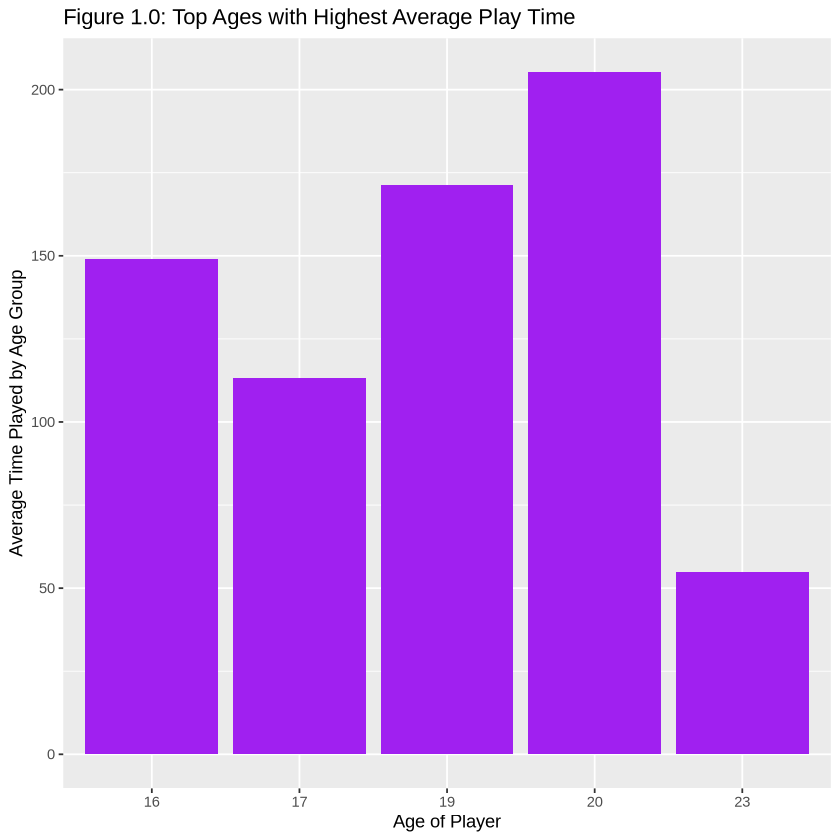

Warning message:
“Removed 1062 rows containing missing values or values outside the scale range
(`geom_point()`).”


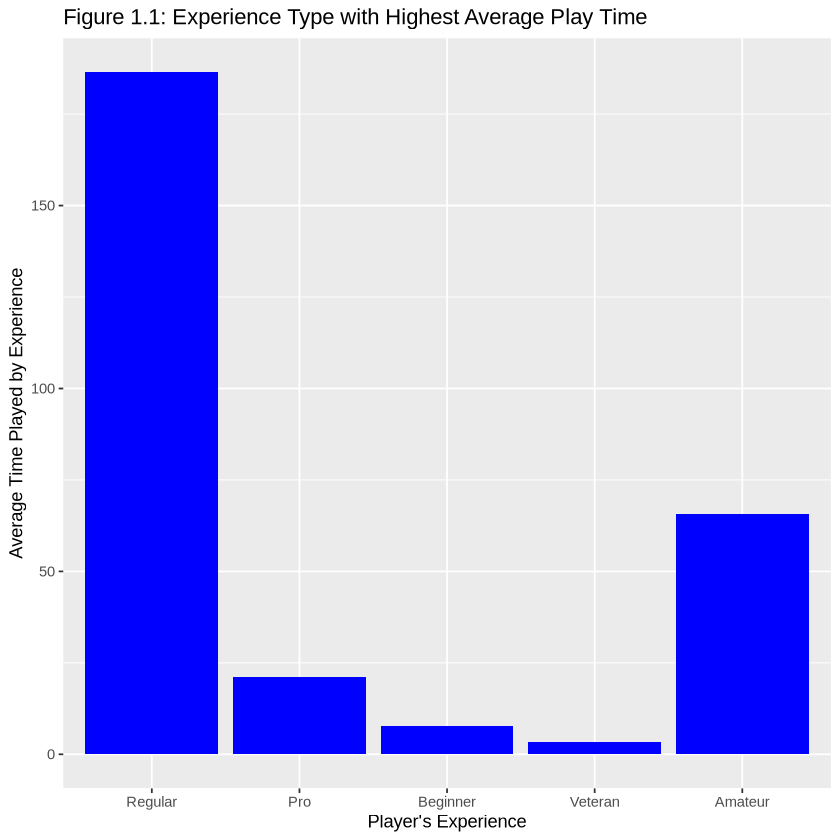

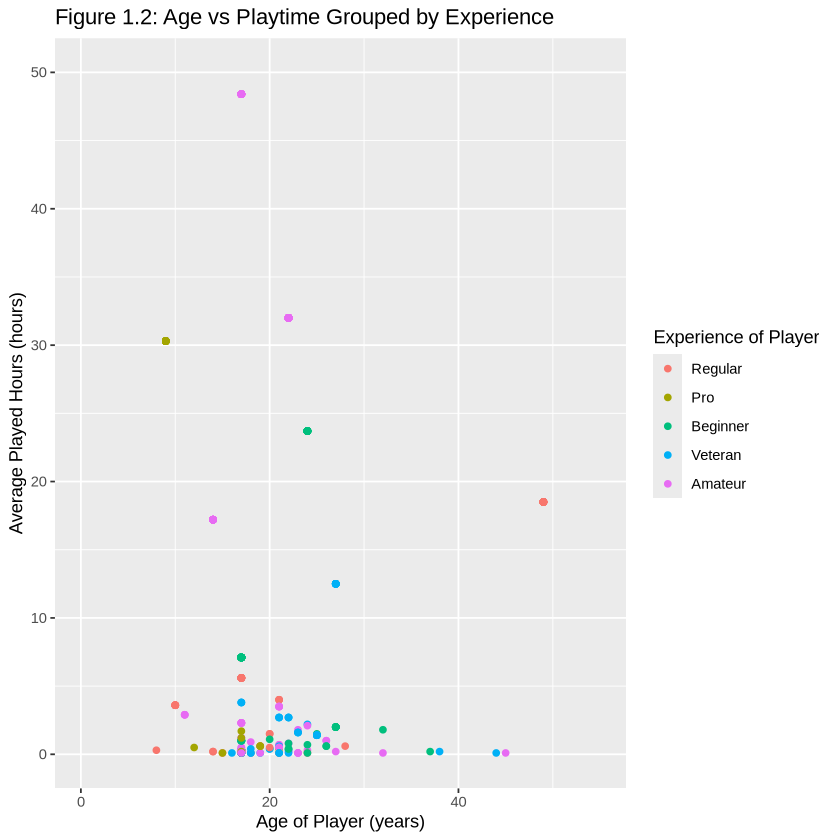

In [5]:
#Bar chart for top 5 ages with their average play time
top_ages <- sesh_diff_final |> #used players set to remove repeated played hours
    group_by(age)|>
    summarize(time = mean(played_hours)) |>
    slice_max(time, n = 5)|>
    arrange(age) |>
    mutate(age = as.character(age))


top_ages_plot <- top_ages |>
    ggplot(aes(x = age, y = time)) +
    geom_bar(stat = "identity", fill = "purple") +
    labs(x = "Age of Player",
    y = "Average Time Played by Age Group",
    title = "Figure 1.0: Top Ages with Highest Average Play Time") 


#Bar chart for Experience level Play time
top_exp <- sesh_diff_final |> #used players set to remove repeated played hours
    group_by(experience)|>
    summarize(time = mean(played_hours)) |>
    slice_max(time, n = 5)

top_exp_plot <- top_exp |>
    ggplot(aes(x = experience, y = time)) +
    geom_bar(stat = "identity", fill = "blue") +
    labs(x = "Player's Experience",
    y = "Average Time Played by Experience",
    title = "Figure 1.1: Experience Type with Highest Average Play Time") 


#Scatter plot for age vs playtime catergorized by experience level

    
exp_plot <- sesh_diff_final|>
    ggplot(aes(x = age, y = played_hours, colour = experience)) +
    geom_point() +
    scale_y_log10() +
    xlab("Age of Player (years)") +
    ylab("Average Played Hours (hours)") +
    labs(colour = "Experience of Player") +
    xlim(0, 55) +
    ylim(0, 50) +
    ggtitle("Figure 1.2: Age vs Playtime Grouped by Experience")



top_ages_plot
top_exp_plot
exp_plot

In [6]:
#Set the seed to ensure reproducibility within our code
set.seed(1234)

#Splitting the data into training and testing sets, Data visualization will utilize the training split
play_split_viz <- initial_split(sesh_diff_final, prop = 0.9, strata = experience)
play_train_viz <- training(play_split_viz)

**Data analysis and classification model building**

In step 1, we are separating the data into the training and testing splits. We pick a split of 90/10, to give the model the biggest amount of data possible to learn from, while also ensuring the testing data is sufficient to test the final model's accuracy. 

In step 2 and 3, we create the cross-validation object and grid object respectively, which we can use in our workflow later on.

Step 4 and 5 are the model and recipe creation respectively, notice how we place 'tune()' in the neighbors argument of the model such that many K values can be tried, and how we scale the predictors in our recipe to ensure that every predictor has equal weight in the classfier.

Step 6 is the workflow, and steps 7 and 8 draw accuracy metrics from each K value. From the visualization, we can tell that K = 5 will yield the highest accuracy, which is why we set 5 to the value of best_k in step 9.

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 137 rows.
               ✖ Assigned data has 138 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 138 to size 137.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 135 rows.
               ✖ Assigned data has 136 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 136 to size 135.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





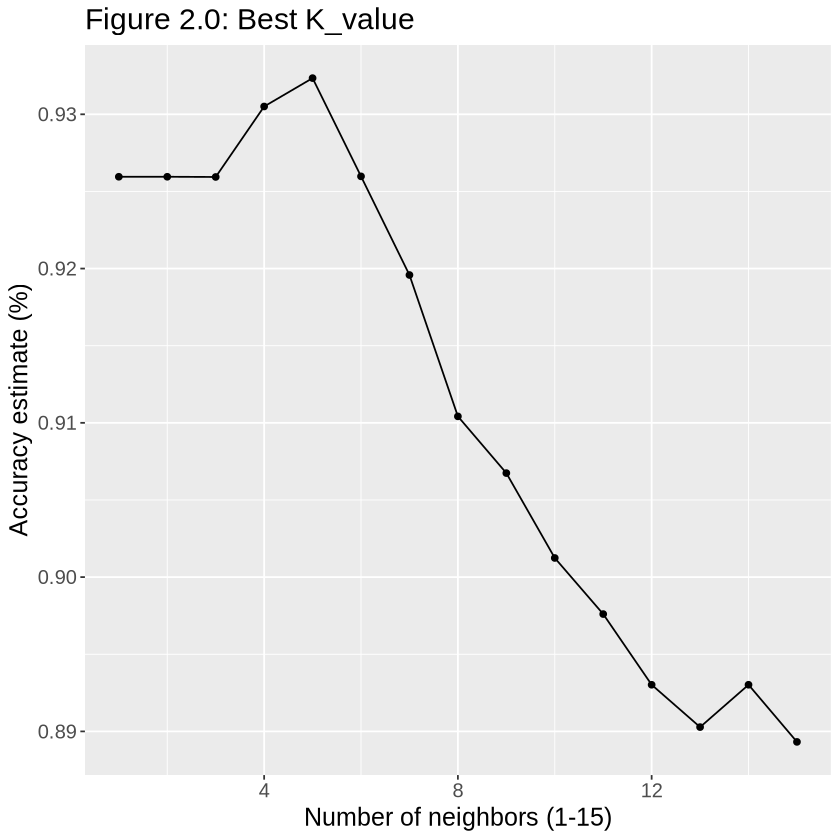

In [7]:
#Set the seed to ensure reproducibility within our code
set.seed(1234)

#Step 1
play_split <- initial_split(sesh_diff_final, prop = 0.9, strata = experience)
play_train <- training(play_split)
play_test <- testing(play_split)

#Step 2
play_vfold <- vfold_cv(play_train, v = 10, strata = experience)

#Step 3
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

#Step 4
play_model <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

#Step 5
play_recipe <- recipe(experience ~ ., data = play_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Step 6
play_results <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_model) |>
    tune_grid(resamples = play_vfold, grid = k_vals) |>
    collect_metrics()

#Step 7
accuracies <- play_results |>
    filter(.metric == 'accuracy')

#Step 8
best_k_graph <- accuracies |>
ggplot(aes(x = neighbors, y = mean)) +
geom_line() +
geom_point() +
labs(x = 'Number of neighbors (1-15)', y = 'Accuracy estimate (%)', title = 'Figure 2.0: Best K_value') +
theme(text = element_text(size = 15))

best_k_graph

#Step 9
best_k <- 5

Since the data obtained in the testing and training split are entirely seed dependant, there is also variability in which K values are the best. 

Hence, picking 5 as the K-value is the best choice in this scenario, since changing the value to a nearby one doesn't decrease the accuracy by too much either. Thus, the K value we choose remains reliable despite uncertainty.

From any point after 5 as a K-value, the function may begin overfitting, hence the decrease in the accuracy.

In [8]:
#Building engine with the best K value
play_model_best <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_k) |>
    set_engine('kknn') |>
    set_mode('classification')

#Building new workflow
play_fit <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_model_best) |>
    fit(data = play_train)

The below section will be analyzing the model's performance on the testing data through different means, such as precision and recall. In conjunction with some of the graphs in the visualization, this can provide vital information to us about what players the researchers might want to target, and how feasible it might be in practice.

First of all, we can classify the 'positive' for this experiment to be the amateur and regular classes, as they show the highest playtime.

By looking at the confusion matrix, we can see that we had little false positives for the amateur and regular columns. This is convenient for our purpose, as having false positives would lead to researchers recruiting for experience levels that might not actually be what they claim, and hence display varied playtime. They do have lower recall values though, which means that there will be a decent amount of false negatives, but in that case researchers at least aren't allocating resources to participants who may not contribute that much data.

In [9]:
#Seeing the accuracy of the predictions by our model
play_fit_predictions <- predict(play_fit, play_test) |>
    bind_cols(play_test)

play_fit_acc <- play_fit_predictions|>
    metrics(truth = experience, estimate = .pred_class) |>
    filter(.metric == 'accuracy')
play_fit_predictions

#Precision
play_fit_predictions |>
    precision(truth = experience, estimate = .pred_class, event_level = 'first')

#Recall
play_fit_predictions |>
    recall(truth = experience, estimate = .pred_class, event_level = 'first')

#Confusion matrix
confusion_matrix <- play_fit_predictions |>
    conf_mat(truth = experience, estimate = .pred_class)
confusion_matrix

.pred_class,experience,played_hours,age,session_playtime
<fct>,<fct>,<dbl>,<dbl>,<dbl>
Beginner,Regular,5.6,17,20
Amateur,Amateur,17.2,14,16
Amateur,Amateur,17.2,14,9
⋮,⋮,⋮,⋮,⋮
Amateur,Amateur,56.1,23,7
Amateur,Amateur,56.1,23,6
Amateur,Amateur,56.1,23,7


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.7182792


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,macro,0.8681004


          Truth
Prediction Regular Pro Beginner Veteran Amateur
  Regular       47   0        0       0       0
  Pro            1   4        1       1       1
  Beginner       1   0        9       0       1
  Veteran        2   0        1       2       2
  Amateur        1   0        0       0      79

**Visualization Results**
-

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 102 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 102 rows containing missing values or values outside the scale range
(`geom_point()`).”


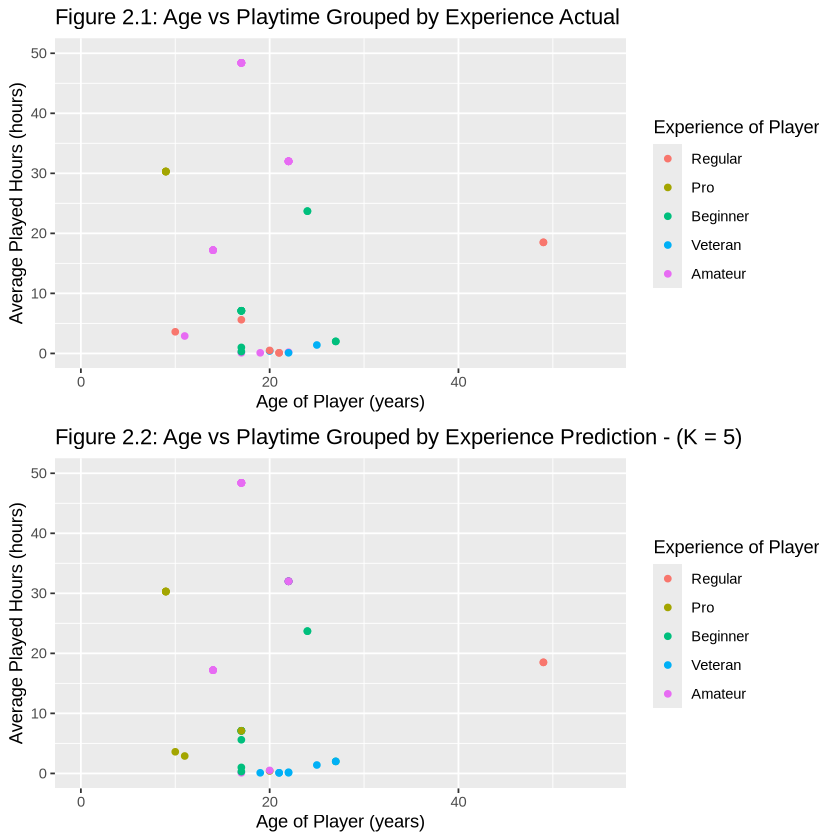

In [15]:
exp_plot_2 <- play_fit_predictions|>
    ggplot(aes(x = age, y = played_hours, colour = experience)) +
    geom_point() +
    scale_y_log10() +
    xlab("Age of Player (years)") +
    ylab("Average Played Hours (hours)") +
    labs(colour = "Experience of Player") +
    xlim(0, 55) +
    ylim(0, 50) +
    ggtitle("Figure 2.1: Age vs Playtime Grouped by Experience Actual")

exp_plot_pred <- play_fit_predictions|>
    ggplot(aes(x = age, y = played_hours, colour = .pred_class)) +
    geom_point() +
    scale_y_log10() +
    xlab("Age of Player (years)") +
    ylab("Average Played Hours (hours)") +
    labs(colour = "Experience of Player") +
    xlim(0, 55) +
    ylim(0, 50) +
    ggtitle("Figure 2.2: Age vs Playtime Grouped by Experience Prediction - (K = 5)")

combined_plot <- grid.arrange(exp_plot_2, exp_plot_pred, ncol = 1)

When comparing the two charts we can see that our prediction chart is similar to the actual data points to an extent. Our model is very accurate in predicting high play times, as amateur players with the large play times are correctly represented. However, we see a deviation in the categorization of points towards the cluster around the age 20 with low average play time. It may be due to our model underrepresenting other experience categories, as it favours one category over others around that area. But, since our researchers are interested in those players with higher play time, the charts show that our model is accurate in predicting the experience associated with higher playtimess.

**Discussion**
-

We found that there is a positive relationship between amateur and regular experience levels and playtime. Based on our model's precision and recall of 0.718 and 0.868 respectively, it is highly likely that there is a relationship between our classifier and predictors. Therefore, from our previous exploratory charts, the ages 16, 19, and 20, and amateur and regular players are highly likely to provide the most data to our researchers, as these categories show a strong relationship to increased playtime.

This isn't what we were expecting; it is common to assume that players with more experience in a game are likely to play more since they show more interest in the game if they self-proclaim themselves as more knowledgeable players. However, based on our findings, players that are versed, but not experts, tend to play more. This may be because on each side of the bell curve—beginners and veterans—they may have either played the game too much or too little to feel interested in playing for long hours.

Because of our findings, the researchers may want to turn their marketing strategies towards this age group's preferences, as well as make the game easily accessible to players of these experience levels. One strategy for age is using social media to market their server using current trends or social media influencers to promote their server. Additionally, since middle-to-lower-experienced players provide the most data, making the server's gameplay easier to onboard, creating entry-level community activities, and introducing progression-based achievements may be more appealing for this category of players.

These findings may further raise the question of what these players do during their time on the server. AFK (away-from-keyboard) gameplay may be pushing the played hours of these groups and may not be the most useful in research, as the players are online but not actively participating in the game. So, tracking what players do within the server may be a good next field to research in order to find active gameplay hours.